# MOD 2 Final Project Submission
* Student name: Bryan DiCarlo
* Student pace: Full Time Online 4/15/19 Cohort
* Scheduled project review date/time: Tuesday June 18 @ 12:30pm
* Instructor name: Rafael Carrasco
* Blog post URL: https://bryan-dicarlo.github.io/hypothesis_testing_and_the_northwind


# Introduction
* For this project, we will be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional trading company.
* Data will be gathered from the database using SQL queries.  After exploring the data, important Business questions will be posed and answered using hypothesis testing


# The Northwind Database
<img src='Northwind_ERD.png'>

# Methodology: 5 steps for the Scientific Method and Hypothesis Testing
1. In each section a general business question will be posed and then investigated.
2. The data to answer the question will be drawn from the database through SQl queries and explored through EDA
3. The hypothesis to be tested will be formulated and stated.  All hypothesis testing will be done at the $\alpha$ = 0.05 level
4. Testing the hypothesis.  The appropriate hypothesis test for each question will be determined. The undelying assumtions of each test will be examined.  The hypothesis will be tested using the appropriate test for each question.
5. The results will be analyzed and it will be determined if we have evidence to reject the null hypothesis or fail to reject the null hypthesis based on the evidence.  Results will be stated.  Conclusions that can be drawn from the experiment will be reported

# Questions to be Explored
* 1. Do discounts have a statistically significant effect on the number of products customers order? Part B: What levels of discounts are significant compared to No Discount?
* 2. Investigating the Revenue Generated from the Different Regions Northwind Serves. Are there differences?
* 3. Split the Northwind customer base into The Americas and Greater Europe to compare spending and revenue from customers on different sides of the globe. Do we find any differences?
* 4. Analyze the number of products sold from each of Northwind's product categories. Do sales differ between product categories?
* 5. Compare Average Sales Totals from 2012-2013 to 2013-2014. Is there statistically significant revenue growth?
* 6. Some interesting questions for future work.  I briefly investigate employee sales below.  It would also be important to know the performance of Northwind's three shipping companies. Data is incomplete but I start this analysis below.


# Imports

In [422]:
from scipy import stats
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Connecting to The Database

In [423]:
# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-06-15 20:09:59,570 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-06-15 20:09:59,572 INFO sqlalchemy.engine.base.Engine ()
2019-06-15 20:09:59,573 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-06-15 20:09:59,574 INFO sqlalchemy.engine.base.Engine ()


## Notes on Exploration of the Database and ERD
1. As is often the case. There are discrepancies between the published ERD and the actual Table and column names contained in the datbase.
2. The table names are singular instead of the plural listed in the ERD.  There are also discrepancies in column names.
3. For sake of space and readability I performed this analysis in a practice notebook before constructing each SQL query
4. This notebook will contain SQl queries  using the corrected information from this analysis


# Question # 1: Do discounts have a statistically significant effect on the number of products customers order? 

## EDA

### From initial inspection all the information needed to answer this question is contained in the OrderDetail table from our database

In [424]:
# Read the OrderDetail table from the database into a dataframe for further analysis
df_orderdetail = pd.read_sql_query(''' SELECT * FROM OrderDetail''', engine)
df_orderdetail.head()

2019-06-15 20:09:59,650 INFO sqlalchemy.engine.base.Engine  SELECT * FROM OrderDetail
2019-06-15 20:09:59,651 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Inspect visually to check for differences in quantity between discounted and non-discounted orders

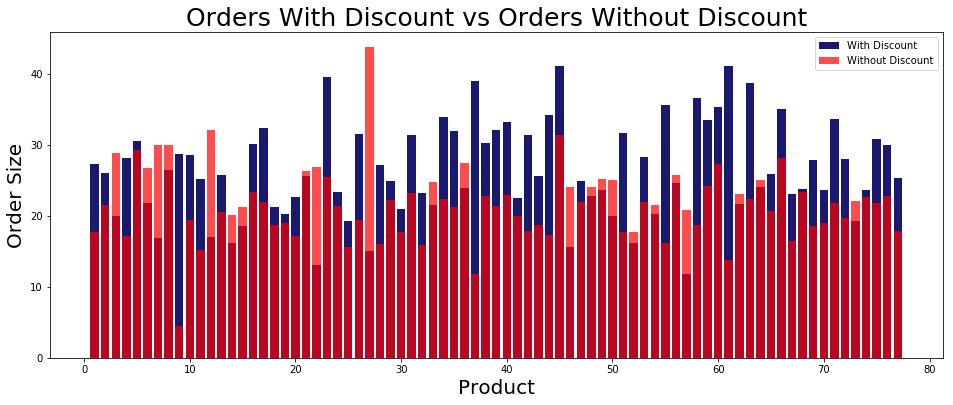

In [425]:
# Separate the data into groups with discount and without discount and compare avg order size visually
disc = df_orderdetail[df_orderdetail['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_disc = df_orderdetail[df_orderdetail['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,6))
plt.bar(disc.index, disc.values, alpha=1, label='With Discount', color='midnightblue')
plt.bar(no_disc.index, no_disc.values, alpha=0.7, label='Without Discount', color='r')
plt.legend()
plt.title('Orders With Discount vs Orders Without Discount', fontsize=25)
plt.xlabel('Product', fontsize=20)
plt.ylabel('Order Size', fontsize=20)
plt.show()


### It does appear that dicounted orders result in higher order quantities overall.  Split the two groups and investigate further

In [426]:
# split the dataframe into discount and no discount and compare the descrptive statistics
discount = df_orderdetail[df_orderdetail['Discount']!=0]['Quantity']
no_discount = df_orderdetail[df_orderdetail['Discount']==0]['Quantity']
discount.describe(), no_discount.describe()

(count    838.000000
 mean      27.109785
 std       20.771439
 min        1.000000
 25%       12.000000
 50%       20.000000
 75%       36.000000
 max      130.000000
 Name: Quantity, dtype: float64, count    1317.000000
 mean       21.715262
 std        17.507493
 min         1.000000
 25%        10.000000
 50%        18.000000
 75%        30.000000
 max       130.000000
 Name: Quantity, dtype: float64)

### This appears to be a good candidate for two sample t-test.  Lets looks at our distributions

In [427]:
#Function to compare experimental and control group distributions and means visually
def compare_2_distributions_vis(control, experimental):
    '''Function will compare the distributions of two sample populations'''
    plt.figure(figsize=(15,6))
    sns.distplot(control, bins = 50, label= "No Discount", color ='springgreen')
    sns.distplot(experimental, bins = 50, label= "Discounted", color='darkblue')
    plt.axvline(x=control.mean(), color='r', linestyle='--', label='No Discount Mean')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--', label='Discounted Mean')
    
    plt.title('No Discount vs Discounted Distributions', fontsize= 18)
    plt.xlabel('No Discount vs Discounted Distributions', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

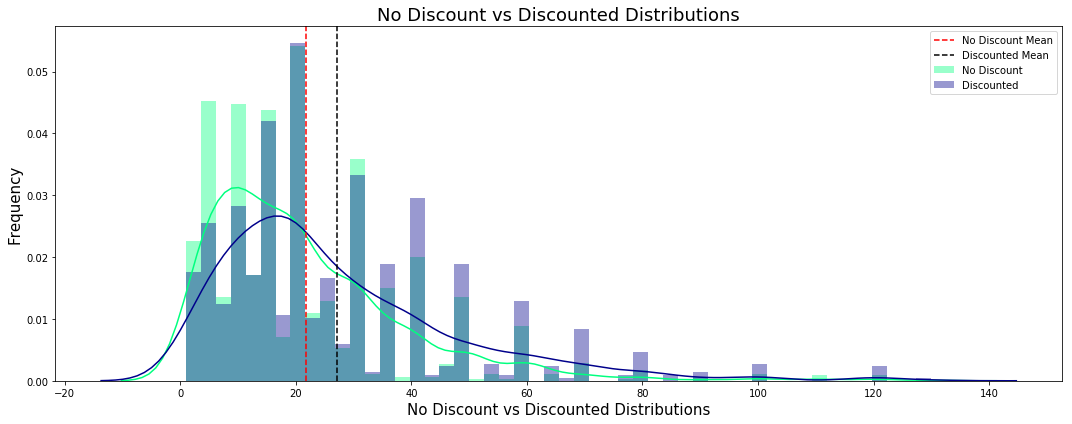

In [428]:
# Plot the distributions with means
compare_2_distributions_vis(no_discount, discount)

### Check for Normality Assumption

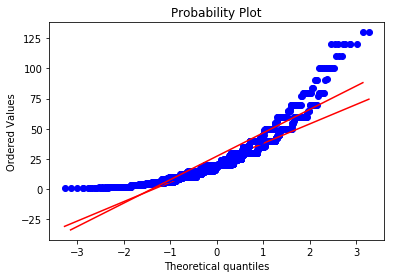

In [429]:
# Investigate the normality of the two distributions with probability plots
stats.probplot(no_discount, plot = plt), stats.probplot(discount, plot = plt)
plt.show()

### Check for Equal Variance Assumption

In [430]:
# Compute the ratio of Standard Deviations 
ratio = np.std(discount)/np.std(no_discount)
print('The ratio of the standard deviations of our two samples is {}'.format(ratio))
print('If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test')

The ratio of the standard deviations of our two samples is 1.1861736681024289
If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test


## Observations from EDA: Test choice for Hypothesis testing
* There appears to be a measurable difference in mean quantity for orders that are Discounted vs Non-Discounted orders
* The average quantity per order for Discounted orders is 27.1
* The average quantity per order for Non-Discounted orders is 21.7
* Our distributions are not completely normally distributed. Due to our large sample sizes this will not adversely affect our t-test
* The ratio of the standard deviations is within range acceptable for a two sample t-test. However it is close to the upper limit
* I will use a two sample t-test with unequal variance (Welch's t-test) to account for this.
* The diiference in means appears to be larger for discounted orders.  I will use a one-tailed hypothesis test to test this observation


## Question # 1: Hypothesis # 1
- $H_0$: Mean of Discounted orders <= Mean Non-Discounted orders
- $H_\alpha$: Mean of Discounted orders > Mean Non-Discounted orders
- $\alpha$ = 0.05

## Welch's Two Sample T-test with unequal variance 

In [431]:
# Testing Hypothesis # 1
tval, pval = stats.ttest_ind(no_discount, discount, equal_var=False)
print("p-value is {}".format(pval/2))
print("p-value is less than 0.05 we can reject the null hypothesis")

p-value is 2.828207145152165e-10
p-value is less than 0.05 we can reject the null hypothesis


### Calculating effect size with the Cohen's d statistic

In [432]:
def cohen_d(group1, group2):
    """ Calculates the Cohen's d statistic as a measure of effect size"""

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [433]:
cohen_d(no_discount, discount)

0.2862724481729283

### Visualize The PDF T-Distribution

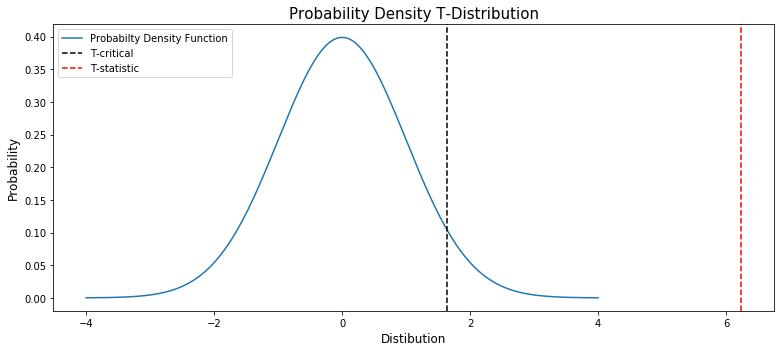

In [434]:
# Visualize t and p_value For a One-tailed test

def visualize_t(t_stat, n_control, n_experimental):
    """Function to visualize the PDF T-Distribution"""

    # initialize a matplotlib "figure"
    plt.figure(figsize=(11,5))

    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)
 
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    dof = (n_control + n_experimental) - 2
    ys = stats.t.pdf(xs, dof, 0, 1)
    # Draw one sided boundary for critical-t
    t_crit = stats.t.ppf(.95, ((n_control +n_experimental)-2))
    plt.plot(xs, ys, label="Probabilty Density Function")
    plt.axvline(t_crit, color='K', linestyle='--', label='T-critical')
    plt.axvline(abs(t_stat), color='r', linestyle='--', label='T-statistic')
    plt.title('Probability Density T-Distribution', fontsize= 15)
    plt.xlabel('Distibution', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return None

n_control = len(no_discount)
n_experimental = len(discount)
visualize_t(tval, n_control, n_experimental)

# Question # 1: Conclusions
* After exploring the Data a difference in the average size of Discounted vs Non-Discounted orders was noticed
* The data was explored to identify the most appropriate hypothesis testing method to test this difference
* The data was well suited for a two sample t-test with unequal variance.
* Our test indicated that the p-value was much less than .05 and we could reject the null hypothesis with a high degree of confidence
* Post hoc analysis seems to confirm this result
* One suprising observation was the Cohen's d statistic. The value was small indicating a small effect size even though our p-value was extremely small.  This is probably due to our large sample size.  Even though the overall effect was relatively small, due to the large sample size, the difference was still statistically significant.
* This gets to the point of properly interpreting p-values and the Cohen's d statistic.  One does not imply the other.  You can have a small effect size and still have very low p-values and high degree of statistical significance.  You are very confident this difference did not happen by chance (as incicated by your p-value).  The difference we measured is still statisticaly significant but the overall difference between the two sample is relatively small as shown by the Cohen's d statistic.

# Question # 1 B: What levels of discounts are significant compared to No Discount

## EDA

In [435]:
# Explore the number of sales in each discount Category
df_orderdetail.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

### The sample size for discount levels [1%, 2%, 3%, 4%, 6%] are too low to be included in our hypothesis testing

In [436]:
# Create a new DataFrame including discount levels with large enough sample sizes to be included in our analysis
a = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]
df_new = df_orderdetail[df_orderdetail.Discount.isin(a)]
df_new.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

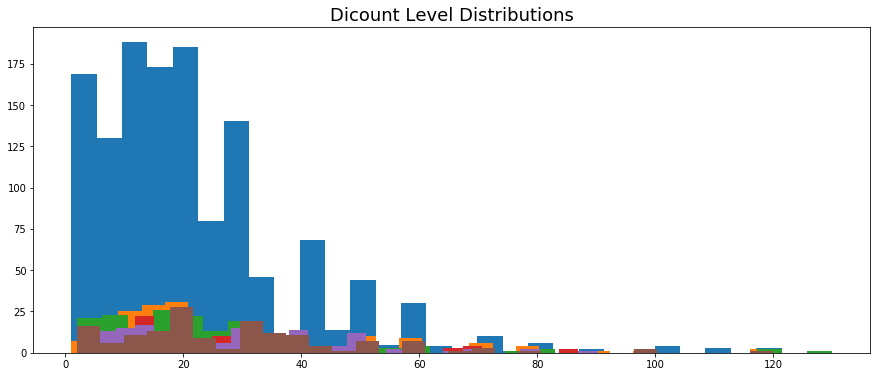

In [437]:
# Plot the Dicount Level Distributions
df_new.groupby('Discount')['Quantity'].hist(figsize=(15, 6), bins=30, grid=False)
plt.title('Dicount Level Distributions', fontsize=18)
plt.show()

### Normality:  It appears that our distributions are "normally enough" distributed.  Our large relative sample sizes will also relax this condition

In [438]:
# Show the 5 point statistics for each dicount category
df_new.groupby('Discount')['Quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0
0.25,154.0,28.240260,20.120570,2.0,15.0,25.0,36.0,120.0


### Variance:  Looking at the STD as a proxy for variance.  The ratio of the std's with the largest spread is 1.26.  All others fall within the the acceptable range of 0.8 to 1.2.  This should not be an issue.  Our plan is to do multiple comparisons with the Tukey's HSD test.  This is a more robust test with included corrective measures.

## Question # 1 B: Hypothesis # 1 B
- $H_0$: Mean of each goup comapred: $\mu_1$ = $\mu_2$
- $H_\alpha$: Mean of each goup comapred: $\mu_1$ $\neq$ $\mu_2$
- $\alpha$ = 0.05

In [439]:
# Set up and print results for Tukey's pairwise comaprison
results = pairwise_tukeyhsd(df_new.Quantity, df_new.Discount, 0.05)
print(results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


## Question # 1 B: Results and Conclusions
* The null hypothesis can be rejected for all discont levels other than 10%. When compared to the control group no-discount.
* We failed to reject the null hypothesis at a discount level of 10%
* Discount levels of 5%, 15%, 20%, and 25% all showed statistically significant differences in order quantity
* This hypothesis test was set up as two tailed test.  However inspection of the means shows that the mean for discounted order quantities is greater than that for the non discounted group
* It can be infered (not proven) that the statistically significant differences seen in this test indicate higher order quantities for the discount levels where the null hypothesis was rejected.

# Business Insight from Question # 1 Hypothesis Testing
* It was shown that offering discounts has a positive effect on the Quantity of items ordered. This can be an important factor in boosting sales
* The mean order quantity was 21.7 for non-discounted goods 
* Interestingly the highest mean order quantities were for orders discounted at 5%, 15% and 25%. They were 28.0, 28.4 and 28.2 respectively
* This indicates that even at lower rates of discounts higher order rates were still observed.
* This lends itself to further investigation.  Experimentation to find the lowest discount rate that still maintains the observed increase in order quantities could certainly improve the bottom line.
* Also interesting was the fact that a discount rate of 10% did not show statistical significance.  The mean was higher than non-discounted orders.  Yet not enough to be statistically significant.
* Offering discounts was shown to increase Order quantities.  Increasing sample size to hone in on the lowest discount that still maintains this trend will be important for increasing sales and revenue. 


# Question # 2: Investigating the Revenue Generated from the Different Regions Northwind Serves 

## Gathering The Data

### The information needed can be found in the Order, OrderDetail and Customer tables from the database

In [440]:
# SQL query joining the Order, OrderDetail and Customer tables to retrieve the data wee need
df_region_revenue = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', engine)

2019-06-15 20:10:03,521 INFO sqlalchemy.engine.base.Engine 
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 
2019-06-15 20:10:03,524 INFO sqlalchemy.engine.base.Engine ()


## EDA

In [441]:
# View the DataFrame
df_region_revenue.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


### Create a column for Order amount taking in to account Quantity, Unit Price and Discount

In [442]:
# Create a column for Order amount or revenue by multiplying Quantity * Unit Price * (1-discount rate)
df_region_revenue["order_amount"] = df_region_revenue['Quantity'] * df_region_revenue["UnitPrice"] * (1 -df_region_revenue["Discount"])
df_region_revenue.head()

,Region,OrderId,Quantity,UnitPrice,Discount,order_amount
0,Western Europe,10248,12,14.0,0.0,168.0
1,Western Europe,10248,10,9.8,0.0,98.0
2,Western Europe,10248,5,34.8,0.0,174.0
3,Western Europe,10249,9,18.6,0.0,167.4
4,Western Europe,10249,40,42.4,0.0,1696.0


### We can scale down our dataframe to include the colums we are interested in Region and Order Amount

In [443]:
#Now that I have calculated total order amounts I can remove the columns I no longer need
df_r_r = df_region_revenue.drop(['OrderId', 'Quantity', 'UnitPrice', 'Discount'], axis = 1)
df_r_r.head()

,Region,order_amount
0,Western Europe,168.0
1,Western Europe,98.0
2,Western Europe,174.0
3,Western Europe,167.4
4,Western Europe,1696.0


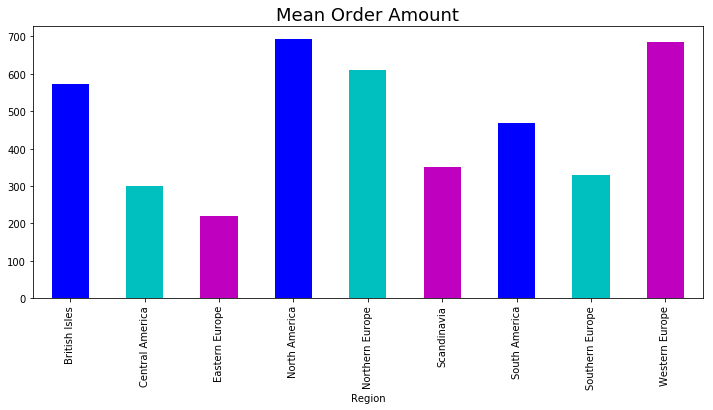

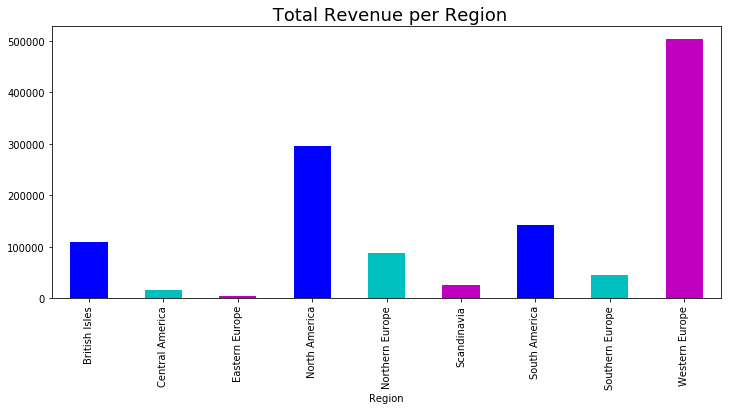

In [444]:
# Visualize Mean Oreder Amount and Total Revenue per Region
df_r_r.groupby('Region')['order_amount'].mean().plot(kind='bar', color=["b", 'c', 'm'], figsize=(12,5))
plt.title("Mean Order Amount", fontsize=18)
plt.show()
df_r_r.groupby('Region')['order_amount'].sum().plot(kind='bar', color=["b", 'c', 'm'], figsize=(12,5))
plt.title(" Total Revenue per Region", fontsize=18)
plt.show()

In [445]:
# Show the 5 point statistics for each Region
df_r_r.groupby('Region')['order_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
British Isles,190.0,573.427447,944.869689,4.80,144.7200,354.500,660.0000,9903.2
Central America,55.0,301.056364,539.362443,20.80,67.0750,196.800,366.0000,3952.5
Eastern Europe,16.0,220.746875,163.075679,22.35,107.5000,190.000,249.3750,591.6
North America,427.0,692.695317,1092.962510,14.00,147.9000,379.950,775.7375,10540.0
Northern Europe,143.0,609.483654,1073.633574,14.40,182.4375,300.000,606.0000,10540.0
Scandinavia,70.0,350.645750,353.425343,17.88,126.0000,259.875,445.5000,2108.0
South America,304.0,469.334895,979.863294,8.64,137.2875,288.750,524.7480,15810.0
Southern Europe,137.0,330.114726,387.244233,7.30,84.0000,207.000,443.7000,2475.8
Western Europe,736.0,684.169033,1018.954073,8.50,183.5375,416.120,811.5000,15019.5


### Check for normality assumption
* It will be difficult to check the normality assumption for each individual group.  I will investigate the two largest contributors North America, Western Europe and Total.
* I plan to use Tukey's pairwise HSD. This will take care of some the heavy lifting for us.  
* As can be seen from the summary statistics the groups from similar size and contribution have similar std and summary statistics.
* The Tukey’s test will compare pairwise.  It will compare the smaller groups with similar normality and variance to smaller groups.  As will it compare the larger groups with similar properties.
* This test is robust and will consider many of these factors for us.  It will take these factors into account and will not reject the null if the two groups differ too greatly. It has this stringency built in.
* It is a fair trade off to be able to compare multiple diverse groups.  It will only reject the null in cases of true differences 


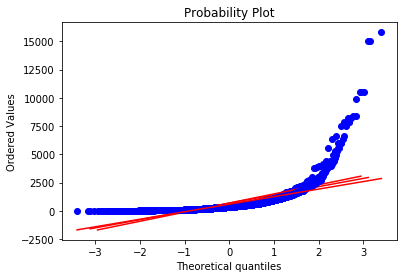

In [446]:
# Investigate the normality of the two distributions with probability plots
stats.probplot(df_r_r[df_r_r.Region == "Western Europe"]["order_amount"], plot = plt), 
stats.probplot(df_r_r[df_r_r.Region == "North America"]["order_amount"], plot = plt),
stats.probplot(df_r_r.order_amount, plot = plt)
plt.show()

### As can be seen our distributions are not perfectly normal
* Deviations from normality are more evident at the tails
* Due to the sample size of our larger regions these will not greatly affect the results
* This is also a good reason to choose Tukey's for our testing method. Descrepancies can be accounted for in pairwise comaprison

### Variance:
*	For similar reasons described above for normality.  The differences in variance will be considered using Tukey’s.
*	For the three samples plotted above the ratio of the standard deviations is close to 1
*	Pairwise comparison will be done for samples with similar variance
*	When comparisons are done between samples with variances that differ widely, we expect the test to fail to reject the null hypothesis
*	Tukey’s will only reject the null when the comparisons are real and significant
*	The test has built in stringency measures when comparing small groups to large groups or groups where the underlying assumptions have not been met


## Question # 2: Hypothesis 
- $H_0$: Mean of each Region comapred: $\mu_1$ = $\mu_2$
- $H_\alpha$: Mean of each Region comapred: $\mu_1$ $\neq$ $\mu_2$
- $\alpha$ = 0.05

### Set up Tukey's HSD pairwise comparison for all Regions

In [447]:
# Tukey's pairwise comparison of Order Amounts from each Customer Region
results2 = pairwise_tukeyhsd(df_r_r['order_amount'], df_r_r['Region'], 0.05)
print(results2)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05         
     group1          group2      meandiff   lower      upper   reject
---------------------------------------------------------------------
 British Isles  Central America -272.3711 -732.8027   188.0605 False 
 British Isles   Eastern Europe -352.6806 -1135.4558  430.0946 False 
 British Isles   North America   119.2679  -142.968   381.5037 False 
 British Isles  Northern Europe  36.0562  -296.8467   368.9591 False 
 British Isles    Scandinavia   -222.7817 -643.2189   197.6555 False 
 British Isles   South America  -104.0926 -382.1856   174.0005 False 
 British Isles  Southern Europe -243.3127 -580.3493   93.7239  False 
 British Isles   Western Europe  110.7416 -133.9562   355.4394 False 
Central America  Eastern Europe  -80.3095 -934.4476   773.8286 False 
Central America  North America   391.639   -39.1539   822.4318 False 
Central America Northern Europe  308.4273 -168.6882   785.5427 False 
Central America   Sc

## Question # 2: Results and Conclusions
* The null hypothesis was rejected for Western Europe when compared To Southern Europe And South America.
* Again, this test is set up as a two tailed test. The mean order amount is greater For Western Europe than either of these regions. This difference can be interpreted that the order amounts are significantly higher than those from Southern Europe and South America. (inferred not proved!)
* The null hypothesis was also rejected for North America compared to Southern Europe.  This can also be inferred as positive difference. The mean order amount from North America is higher than that of Southern Europe.  Our test shows that this difference is unlikely from chance alone.
* Also, it should be noted that some regions have substantial differences in means.  However, the Tukey's test was unable to reject the null Hypothesis.  This give us evidence of the stringency built into the Tukey's test.  Even though the difference in means was relatively large.  Tukey's failed to reject the null hypothesis.  This is likely because those samples did not fully meet the underlying assumptions and were penalized.  That is the power of this test


## Business insight from Question 2:
* It can be seen from the graphs above that customers in Western Europe are the biggest contributor to Northwind’s Revenue.
* It should also be noted that North America, The UK, Northern Europe and South America all have high mean order amounts although they spend less overall than Western Europe.
* Perhaps marketing should be increased these four areas.  These areas are already buying products from Northwind in high amounts when they do order.  Increased Marketing could increase the overall number of orders from these areas.
* Another Consideration is to do some market research and perhaps introduce more products that are important to people in these regions.
* These regions are ordering in quantity when they do place orders. Research and marketing can identify products and strategies to increase the overall revenue from these regions.



# Question # 3: Split the Northwind customer base into The Americas and Greater Europe To compare spending and revenue from customers on different sides of the globe

### Northwind is a global trading company.  Lets investigate closer, the spending habits form customers from different sides of the globe, to see if we can find any insight or differences.

## Gathering the Data
* This is an interesting question that was raised when I pulled the data from the database for the previous question.
* I believe it is worth looking into.
* We can make some modifications to the datframe we pulled in our previous SQL query to investigate this question


## Modify and split our previous dataframe. One for the Americas and one for Greater Europe (or everything else)

In [448]:
# Create a new DataFrame including discount levels with large enough sample sizes to be included in our analysis
b = ['North America', 'South America', 'Central America']
df_americas = df_r_r[df_r_r.Region.isin(b)]
df_ge = df_r_r[~df_r_r.Region.isin(b)]

## EDA

In [449]:
# Show the unique Regions contained in the Americas dataframe
df_americas.Region.unique()

array(['South America', 'Central America', 'North America'], dtype=object)

In [450]:
# Show the unique Regions contained in the Greater Europe dataframe
df_ge.Region.unique()

array(['Western Europe', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [451]:
#View the head of the Americas Data Frame
df_americas.head()

,Region,order_amount
5,South America,77.0
6,South America,1261.4
7,South America,214.2
14,South America,200.0
15,South America,604.8


In [452]:
#View the head of the Greater Europe Data Frame
df_ge.head()

,Region,order_amount
0,Western Europe,168.0
1,Western Europe,98.0
2,Western Europe,174.0
3,Western Europe,167.4
4,Western Europe,1696.0


## Slightly modify function to visualize Distributions

In [453]:
#Function to compare experimental and control group distributions and means visually
def compare_2_distributions(control, experimental):
    '''Function will compare the distributions of two sample populations'''
    plt.figure(figsize=(15,6))
    sns.distplot(control, bins = 50, label= "Americas", color ='r')
    sns.distplot(experimental, bins = 50, label= "Greater Europe", color='darkblue')
    plt.axvline(x=control.mean(), color='r', linestyle=':', label='Americas Mean')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--', label='Greater Europe Mean')
    
    plt.title('Order Amounts Americas vs Greater Europe Distributions', fontsize= 18)
    plt.xlabel('Order Amounts Americas vs Greater Europe Distributions', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

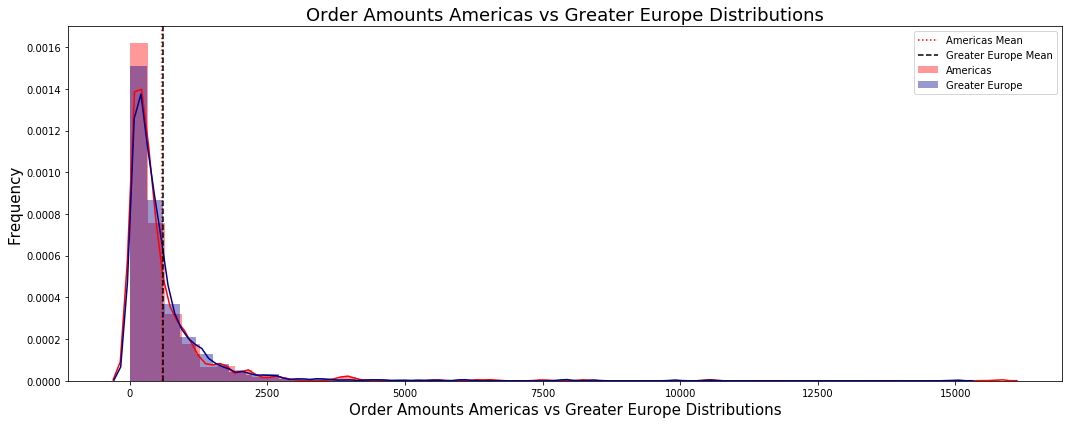

In [454]:
# Visualize our distributions with the means displayed
compare_2_distributions(df_americas.order_amount, df_ge.order_amount)

## The Distribution looks Ok but there does not appear to be much difference in the means

In [455]:
# Print the 5 point Statistics for each of our Distributions for Order Amounts
df_americas.order_amount.describe(), df_ge.order_amount.describe()

(count      786.000000
 mean       578.901792
 std       1027.605847
 min          8.640000
 25%        138.250000
 50%        315.000000
 75%        640.000000
 max      15810.000000
 Name: order_amount, dtype: float64, count     1292.000000
 mean       598.265214
 std        942.558348
 min          4.800000
 25%        156.787500
 50%        357.250000
 75%        678.800000
 max      15019.500000
 Name: order_amount, dtype: float64)

## Check visually for Noramlity assumption

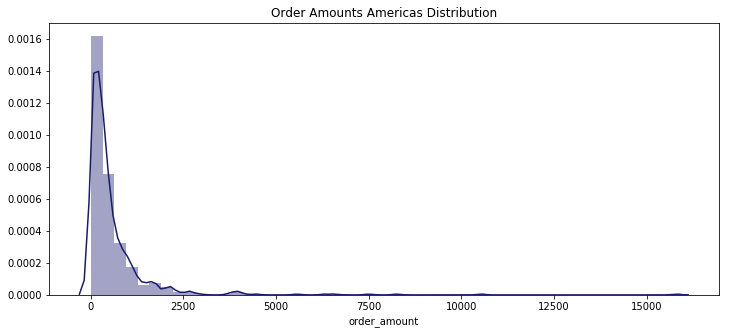

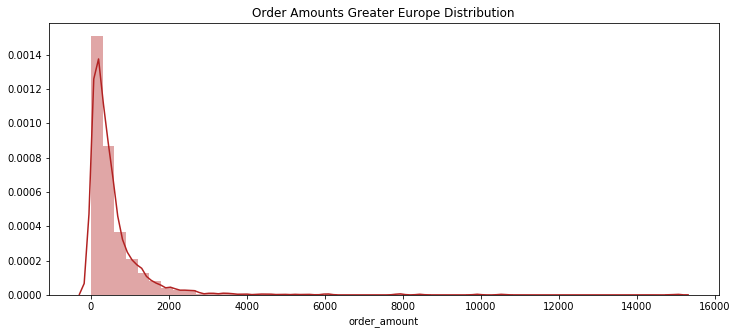

In [456]:
# Plot the Distplot of our Distributions with KDE to check for narmality
plt.figure(figsize=(12,5))
sns.distplot(df_americas.order_amount, bins=50, kde=True, color="midnightblue")
plt.title("Order Amounts Americas Distribution")
plt.show()
plt.figure(figsize=(12,5))
sns.distplot(df_ge.order_amount, bins=50, kde=True, color='firebrick')
plt.title("Order Amounts Greater Europe Distribution")
plt.show()

### From the inspection above and considering sample size or Distributions can be considered normal for testing

## Check for Equal Variance Assumption

In [457]:
# Compare the ratio of the Standard Deviations
ratio2 = np.std(df_americas.order_amount)/np.std(df_ge.order_amount)
print('The ratio of the standard deviations of our two samples is {}'.format(ratio2))
print('If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test')

The ratio of the standard deviations of our two samples is 1.0899586277534457
If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test


## The underlying assumtions have been met.  This is a good candidate for 2 sample t-test

## Question # 3: Hypothesis 
- $H_0$: Mean Americas $\mu_1$ = $\mu_2$  Mean Greater Europe
- $H_\alpha$: Mean of Americas $\mu_1$ $\neq$ $\mu_2$ Mean Greater Europe
- $\alpha$ = 0.05

In [458]:
# Testing Hypothesis # 3
tval2, pval2 = stats.ttest_ind(df_americas.order_amount, df_ge.order_amount)
print("p-value is {}".format(pval2))
print("p-value is greater than 0.05 we fail to reject the null hypothesis")

p-value is 0.6608754677717239
p-value is greater than 0.05 we fail to reject the null hypothesis


## We failed to reject the null hypothesis

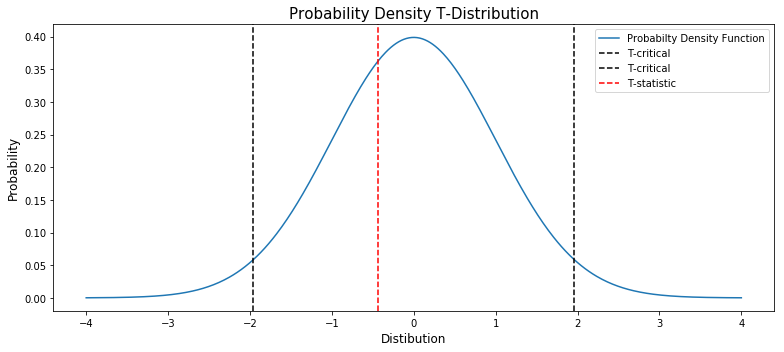

In [459]:
# Visualize t and p_value

def visualize_t_two_tail(t_stat, n_control, n_experimental):
    """Function to visualize the PDF T-Distribution"""

    # initialize a matplotlib "figure"
    plt.figure(figsize=(11,5))

    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)
 
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    dof = (n_control + n_experimental) - 2
    ys = stats.t.pdf(xs, dof, 0, 1)
    # Draw one sided boundary for critical-t
    t_crit = stats.t.ppf(.975, ((n_control +n_experimental)-2))
    plt.plot(xs, ys, label="Probabilty Density Function")
    plt.axvline(t_crit, color='K', linestyle='--', label='T-critical')
    plt.axvline(-t_crit, color='K', linestyle='--', label='T-critical')
    plt.axvline(t_stat, color='r', linestyle='--', label='T-statistic')
    plt.title('Probability Density T-Distribution', fontsize= 15)
    plt.xlabel('Distibution', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return None

n_control = len(df_americas.order_amount)
n_experimental = len(df_ge.order_amount)
visualize_t_two_tail(tval2, n_control, n_experimental)

### Calculate Cohen's d statistic

In [460]:
print("The Cohen's d statistic is {}".format(cohen_d(df_americas.order_amount, df_ge.order_amount)))

The Cohen's d statistic is 0.019847713624031035


## Question # 3: Results and Conclusions
* We failed to reject the null hypothesis
* This indicates that the mean order amounts form the Americas and Greater Europe do not differ statistically
* In fact it appears that the mean order amounts from from these two areas of the globe are very similar

## Question # 3: Business Insight
* Failing to reject the null hypothesis in this investigation is not bad news for Northwind
* It is good news, and why it was important to investigate this question
* Northwind Traders is an International trading company
* It is great news to know that the average amount for orders placed was similar for different areas of the customer base
* While Western Europe still produces the highest overall revenue.  It is good to know that average order amounts are still high in many areas.
* This means that Northwind’s products are appealing to many regions.  Customers are ordering.
* Steps can be taken in marketing and product development to enhance the total sales in other regions


# Question # 4: Analyze the amount of products sold from each of Northwind's product categories

## The information we need can be found in the Product, Order Detail and Category tables

In [461]:
# Read the needed data into a dataframe from the tables listed above
df_sales_per_category = pd.read_sql_query('''
SELECT p.Id, c.CategoryName, od.Quantity
FROM [Product] p
INNER JOIN [OrderDetail] od ON od.ProductId = p.Id
INNER JOIN [Category] c ON c.Id = p.CategoryId
 ''', engine)

2019-06-15 20:10:07,515 INFO sqlalchemy.engine.base.Engine 
SELECT p.Id, c.CategoryName, od.Quantity
FROM [Product] p
INNER JOIN [OrderDetail] od ON od.ProductId = p.Id
INNER JOIN [Category] c ON c.Id = p.CategoryId
 
2019-06-15 20:10:07,517 INFO sqlalchemy.engine.base.Engine ()


## EDA

In [462]:
# Inspect the first 5 rows of our datframe
df_sales_per_category.head()

,Id,CategoryName,Quantity
0,11,Dairy Products,12
1,42,Grains/Cereals,10
2,72,Dairy Products,5
3,14,Produce,9
4,51,Produce,40


In [463]:
# Get a count for the number of products sold in each category
df_sales_per_category.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

In [464]:
# Get the 5 point statistics for quantity sold in each category
df_sales_per_category.groupby('CategoryName')['Quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
CategoryName,,,,,,,,
Beverages,404.0,23.594059,19.222830,2.0,10.0,20.0,30.00,130.0
Condiments,216.0,24.527778,19.761818,1.0,10.0,20.0,30.00,120.0
Confections,334.0,23.670659,17.264570,1.0,10.0,20.0,34.25,120.0
Dairy Products,366.0,24.997268,18.797770,1.0,10.0,20.0,35.00,110.0
Grains/Cereals,196.0,23.275510,18.253924,2.0,10.0,20.0,30.00,130.0
Meat/Poultry,173.0,24.271676,22.238955,2.0,10.0,18.0,30.00,120.0
Produce,136.0,21.985294,18.490031,1.0,10.0,19.0,30.00,120.0
Seafood,330.0,23.275758,19.161917,1.0,10.0,20.0,30.00,120.0


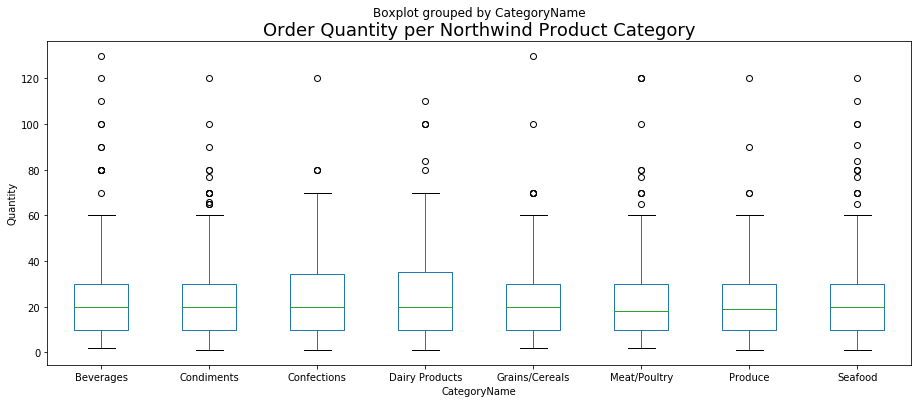

In [465]:
# Box and Whisker Plots of Order Quantity per Northwind Product Category         
df_sales_per_category.boxplot(column='Quantity', by='CategoryName', figsize=(15, 6), grid=False)
plt.title('Order Quantity per Northwind Product Category', fontsize=18)
plt.ylabel("Quantity")
plt.show()

## Investigate the distributions for Normality

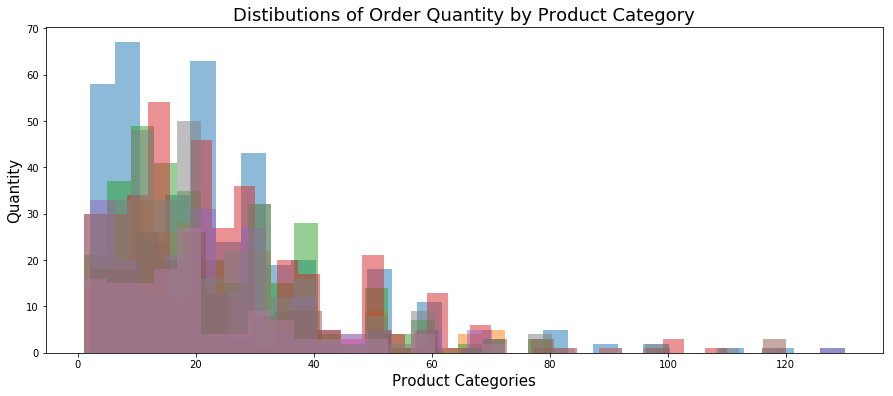

In [466]:
# Plot of Distibutions of Order Quantity by Product Category
df_sales_per_category.groupby('CategoryName')['Quantity'].hist(figsize=(15, 6), bins=30, alpha=.5, grid=False)
plt.title('Distibutions of Order Quantity by Product Category', fontsize=18)
plt.xlabel('Product Categories', fontsize=15)
plt.ylabel('Quantity', fontsize=15)
plt.show()

### Notes on the Normality assumtion for this test:
* Distributions are not completely normal but "normal enough"
* Distributions all follow the same general trend
* Sample size is over 100 for each category, samples follow the same general trend. Normality assumption will not be violated
* This test is a good candidate for the Tukey's HSD test

## Check for equal variance:
* The largest ratio of standard deviations between Categories is 1.29
* All other ratios are close to 1
* This test is a good candidate for the Tukey's HSD pairwise comparison

## Question # 4: Hypothesis
- $H_0$: Mean of each Product Category comapred: $\mu_1$ = $\mu_2$
- $H_\alpha$: Mean of each Product Category comapred: $\mu_1$ $\neq$ $\mu_2$
- $\alpha$ = 0.05

### Set up the Tukey's test for pairwise comaprison of the Order Quantity means for each Product Category

In [467]:
# Tukey's pairwise comparison of Order Amounts from each Customer Region
results3 = pairwise_tukeyhsd(df_sales_per_category.Quantity, df_sales_per_category.CategoryName, 0.05)
print(results3)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower  upper  reject
------------------------------------------------------------
  Beverages      Condiments    0.9337  -3.9346 5.802  False 
  Beverages     Confections    0.0766  -4.1947 4.3479 False 
  Beverages    Dairy Products  1.4032  -2.7647 5.5711 False 
  Beverages    Grains/Cereals -0.3185  -5.3461 4.709  False 
  Beverages     Meat/Poultry   0.6776  -4.5701 5.9254 False 
  Beverages       Produce     -1.6088  -7.3346 4.117  False 
  Beverages       Seafood     -0.3183  -4.6038 3.9672 False 
  Condiments    Confections   -0.8571    -5.9  4.1858 False 
  Condiments   Dairy Products  0.4695  -4.4861 5.4251 False 
  Condiments   Grains/Cereals -1.2523  -6.9499 4.4454 False 
  Condiments    Meat/Poultry  -0.2561  -6.1489 5.6367 False 
  Condiments      Produce     -2.5425  -8.8648 3.7798 False 
  Condiments      Seafood      -1.252  -6.3069 3.8029 False 
 Confections   Dairy Pro

## Question # 4: Results and Conclusions
* We failed to reject the Null Hypothesis in all comaprisons
* This indicates that the mean order size is similar across all categories

## Question # 4: Business Insight
* This is actually good news for Northwind
* This means that no individual Product Category is lagging behind the others in terms of quantities ordered
* All product categories seeem to be selling equally well in terms of quantity per order


# Question # 5: Compare Average Sales Totals from 2012-2013 to 2013-2014
* Our Data is a subset of the Northwind database
* The dates we have access to start in mid-2012 and run through mid-2014
* In order to address this question, I will split the data into 2 equal halves based on order id
*  This is a good estimation of average sales from 2012-2013 to 2013-2014 but not exact
*  What we will be comparing is the average order revenue from the first half of orders placed with Northwind to the average order revenue from the second half of orders placed with Northwind.
* This was a necessary given the subset of information we have access to in order to make a fair comparison
* This will allow us to see if the average order revenue has increased (or decreased) by looking at the first and second half of all orders placed with Northwind.


## Obtaining the Data: the data we need can be found in the Order and Order Details tables

In [468]:
# Query the database to retrieve the needed data
sales_1st_half = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Sales_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE od.OrderId BETWEEN 10248 AND 10662
                            GROUP BY od.OrderId
                    ''', engine)

sales_2nd_half = pd.read_sql_query('''SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Sales_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE od.OrderId BETWEEN 10663 AND 11077
                            GROUP BY od.OrderId
                    ''', engine)

2019-06-15 20:10:09,215 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Sales_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE od.OrderId BETWEEN 10248 AND 10662
                            GROUP BY od.OrderId
                    
2019-06-15 20:10:09,217 INFO sqlalchemy.engine.base.Engine ()
2019-06-15 20:10:09,234 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId,
                            SUM((od.UnitPrice * (1 - od.Discount)) * od.Quantity) Sales_total
                            FROM OrderDetail od
                            JOIN [Order] o ON od.OrderId = o.Id
                            WHERE od.OrderId BETWEEN 10663 AND 11077
                            GROUP BY od.OrderId
                    
2019-06-15 20:10:09,237 INFO sqlalchemy.engine.base.Engine ()


In [469]:
# Inspect the first 5 rows of the datframe
sales_1st_half.head()

,OrderId,Sales_total
0,10248,440.00
1,10249,1863.40
2,10250,1552.60
3,10251,654.06
4,10252,3597.90


In [470]:
# Inspect the first 5 rows of the datframe
sales_2nd_half.head()

,OrderId,Sales_total
0,10663,1930.4000
1,10664,1288.3875
2,10665,1295.0000
3,10666,4666.9400
4,10667,1536.8000


In [471]:
# Look at the 5 point statistics for Sales_total for each
sales_1st_half.Sales_total.describe(), sales_2nd_half.Sales_total.describe()

(count      415.000000
 mean      1454.145825
 std       1653.823835
 min         23.800000
 25%        445.300000
 50%        965.000000
 75%       1822.300000
 max      11188.400000
 Name: Sales_total, dtype: float64, count      415.000000
 mean      1595.957884
 std       2018.013646
 min         12.500000
 25%        473.805000
 50%        932.000000
 75%       1933.200000
 max      16387.500000
 Name: Sales_total, dtype: float64)

### Compare Distributions and Means

In [472]:
#Function to compare experimental and control group distributions and means visually
def compare_2_distributions_q5(control, experimental):
    '''Function will compare the distributions of two sample populations'''
    plt.figure(figsize=(15,6))
    sns.distplot(control, bins = 50, label= "1st Half Sales", color ='c')
    sns.distplot(experimental, bins = 50, label= "2nd Half Sales", color='darkgreen')
    plt.axvline(x=control.mean(), color='r', linestyle='--', label='1st Half Sales Mean')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--', label='2nd Half Sales Mean')
    
    plt.title('1st Half Sales vs 2nd Half Sales Distributions', fontsize= 18)
    plt.xlabel('1st Half Sales vs 2nd Half Sales Distributions', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

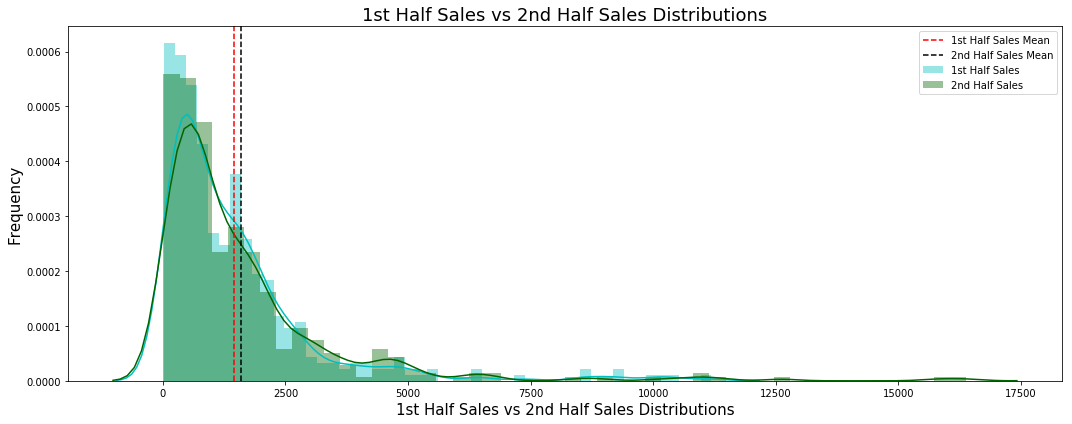

In [473]:
# Plot the distribution with Means displayed
compare_2_distributions_q5(sales_1st_half.Sales_total, sales_2nd_half.Sales_total)

### This appears to be normal enough for comaprison.  We have over 400 samples in each group

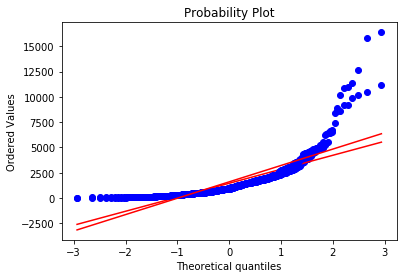

In [474]:
# Investigate the normality of the two distributions with probability plots
stats.probplot(sales_1st_half.Sales_total, plot = plt), 
stats.probplot(sales_2nd_half.Sales_total, plot = plt),
plt.show()

### Some deviation from Normality at the tails but over all it looks good

## Check for equal variance

In [475]:
# Check for equal variance using the ratio of the standard deviations
ratio3 = sales_1st_half.Sales_total.std()/sales_2nd_half.Sales_total.std()
print('The ratio of the standard deviations of our two samples is {}'.format(ratio3))
print('If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test')

The ratio of the standard deviations of our two samples is 0.819530550853333
If the ratio is between 0.8 and 1.2 we are in line with the assumptions of our test


## Choice for Hypothesis Test
* Our Normality and sample size indicate a two sample t-test can be used to test our hypothesis
* Our variance is closer to the lower limit for our test.  I will use a (Welch's) t-test for unequal variance
* The mean 2nd half Sales total per order is slightly greater than that of the 1st half
* This will be a one tailed t-test testing Mean 2nd half Sales total per order > Mean 1st half Sales total per order as our alternative hypothesis

## Question # 5: Hypothesis 
- $H_0$: Mean 2nd half Sales total per order <= Mean 1st half Sales total per order
- $H_\alpha$: Mean 2nd half Sales total per order > Mean 1st half Sales total per order
- $\alpha$ = 0.05

### Setting up the two sample t-test with unequal variance

In [476]:
# Testing Hypothesis # 5
tval3, pval3 = stats.ttest_ind(sales_1st_half.Sales_total, sales_2nd_half.Sales_total, equal_var=False)
print("p-value is {}".format(pval3/2))
print("p-value is greater than 0.05 we fail to reject the null hypothesis")

p-value is 0.13426139364746337
p-value is greater than 0.05 we fail to reject the null hypothesis


### We failed to reject the Null Hypothesis

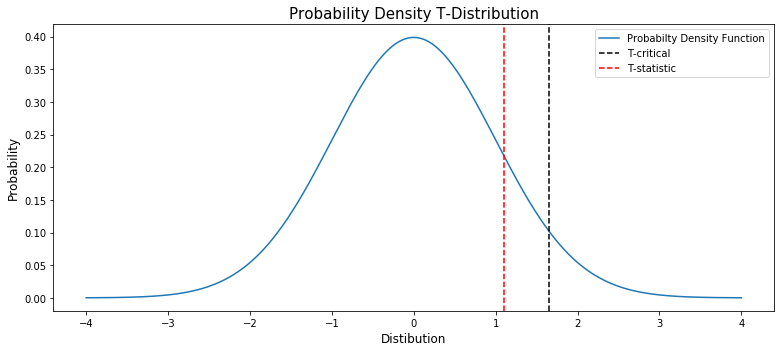

In [477]:
# Visualize the PDF T-Distribution
n_control = len(sales_1st_half.Sales_total)
n_experimental = len(sales_2nd_half.Sales_total)
visualize_t(tval3, n_control, n_experimental)

### We Can that the T-statistic is less than the T-critical value at alpha=0.05. The Null Hypothesis is rejected

# Question # 5: Results and Conclusions
* Average order totals were slightly higher in the second half. 
* However, a statistically significant difference was not seen, and we failed to reject the null hypothesis


# Question # 5: Business Insight
* We are working with data from a limited time period, more data would certainly help us gage the revenue growth for Northwind
* We had to split our data into data into equal groups for fair comparison.  We compared the average order totals for the first half group and compared with the second half group.
* As the table below illustrates this was a fair comparison.  Total revenue and average order totals were slightly higher for the second half group in both cases.  In roughly the same proportion.
* These increases were not at a level where a statistically significant difference could be found.
* Overall it appears that Northwind made progress form the first half to the second half.
* Multi-year data split into months or quarters would be a great help to judge Northwind’s revenue growth in the future



In [478]:
data1 = {'1st Half': [sales_1st_half.Sales_total.sum(), sales_1st_half.Sales_total.mean()], 
         '2nd Half': [sales_2nd_half.Sales_total.sum(), sales_2nd_half.Sales_total.mean()]}
columns1 = ["Total Revenue", "Average Order Total"]
df_rev = pd.DataFrame.from_dict(data1, orient='index', columns=columns1)
df_rev.head()

,Total Revenue,Average Order Total
1st Half,603470.5175,1454.145825
2nd Half,662322.5220,1595.957884


# Conclusions
* It was found that discounts do have a statistically significant positive effect on the number of items ordered
* It was found that the levels of discount with a statistically significant effect were 5%, 15%, 20%, 25%
* Interestingly 5% discount had roughly the same effect as 25% discount.  Further investigation and experimentation could help narrow down the lowest discount level that still produces these results.  This would help profit margin
* It was found that average orders were statistically higher for western Europe compared to South America and Southern Europe. A statistical difference was also seen for North America and Southern Europe
* Western Europe contributes the most revenue to Northwind's bottom line.  However, several other regions were found to have average order amounts close to Western Europe. Since these regions are already have high order totals, future marketing could help increase overall spending in these regions.
* We divided up the orders from the customer base into broader regions.  the Americas and greater Europe.  No statistical difference in order amounts was seen.
* This can be viewed as a positive sign. Northwind is a global trading company. One would hope that sales do equally well around the globe.  We found evidence that this is likely the case.
* We also compared average sales among the different product categories.  No statistical difference was seen. Again, this can be viewed as good news.  As a company we would like all the products we offer to sell equally well.  This indeed appears to be the case
* We also split the orders into first half and second half.  To investigate if revenue has grown.  No statistical difference was found. However, it does appear that total revenue and average amount per sale is trending upward.


#  Business Recomendations
* Discounts Increase Sales
* Do more experimentation with discounts.  Find the lowest discount that consistently drives sales. This will increase profit.
* Market more to the US, the UK Northern Europe and South America. These countries already have large quantities per order.  Marketing can increase the number of orders and the overall revenue from these regions.
* Product categories seem to do equally well overall.  It would be interesting to test some market specific product launches. Test to see if this increased overall revenue by boosting regional sales.  
* Get more multi-year sales data so we can better track the growth of Northwind.
* Get arrival times for shippers. Delivery time is important for customer satisfaction

# Future Directions
* Certainly, Multi-year data would be very useful in future analysis
* This would be useful for many different analyses.  Keeping track of revenue growth chief among them
* It would also be nice to add more quantitative business metrics to our database
* Business Metrics that you would normally see in quarterly or yearly business report.
* There are very few Quantitative measures contained in the database. In most case data had to be connected back with order amount and quantity. As there were some the only quantitative features that could be measured
* Adding more useful information like the shipping information I explore below



### It would be interesting to see how Shipping Companies perform

In [479]:
# Get what information we have about shipping times
df_shipper = pd.read_sql_query('''
SELECT o.OrderDate, o.ShippedDate, od.Quantity, s.CompanyName
FROM [Order] o
INNER JOIN [OrderDetail] od ON od.OrderId = o.Id
INNER JOIN [Shipper] s ON s.Id = o.ShipVia
 ''', engine)

2019-06-15 20:10:11,108 INFO sqlalchemy.engine.base.Engine 
SELECT o.OrderDate, o.ShippedDate, od.Quantity, s.CompanyName
FROM [Order] o
INNER JOIN [OrderDetail] od ON od.OrderId = o.Id
INNER JOIN [Shipper] s ON s.Id = o.ShipVia
 
2019-06-15 20:10:11,109 INFO sqlalchemy.engine.base.Engine ()


In [480]:
df_shipper.head()

,OrderDate,ShippedDate,Quantity,CompanyName
0,2012-07-04,2012-07-16,12,Federal Shipping
1,2012-07-04,2012-07-16,10,Federal Shipping
2,2012-07-04,2012-07-16,5,Federal Shipping
3,2012-07-05,2012-07-10,9,Speedy Express
4,2012-07-05,2012-07-10,40,Speedy Express


### We only have information regarding the order date and shipping date. I will analyze this.  But it would actually helpful if in the future we actually could include arrival date.  This would probably be most relevant to the company and customer

In [481]:
# Convert to datetime to get the number of days it took from order date to ship date
df_shipper.OrderDate = pd.to_datetime(df_shipper.OrderDate)
df_shipper.ShippedDate = pd.to_datetime(df_shipper.ShippedDate)
df_shipper['time_to_ship'] = df_shipper.ShippedDate - df_shipper.OrderDate

In [482]:
# Now convert the number days to a float for anlysis
df_shipper.time_to_ship = df_shipper.time_to_ship.dt.days

### Part of this reason this section is in future work is because the data is incomplete.  The data at the very bottom of this data frame is not in the same format and will not convert to datetime correctly.  This gives NaN values wich are not compatable with the Tukey's Test

In [483]:
df_sh = df_shipper.iloc[:1800]


In [484]:
df_sh.groupby('CompanyName').mean()

,Quantity,time_to_ship
CompanyName,,
Federal Shipping,23.657343,7.676573
Speedy Express,25.090253,8.456679
United Package,23.157270,9.204748


### I will not do the full EDA and anlysis but just for fun lets run a Tukey's test

In [485]:
# Tukey's pairwise comparison of Shipping Companies' time to ship.  Lets see if we can see a difference between companies
results4 = pairwise_tukeyhsd(df_sh.time_to_ship, df_sh.CompanyName, 0.05)
print(results4)

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
     group1          group2     meandiff  lower  upper  reject
--------------------------------------------------------------
Federal Shipping Speedy Express  0.7801  -0.1767 1.7369 False 
Federal Shipping United Package  1.5282   0.6157 2.4407  True 
 Speedy Express  United Package  0.7481  -0.1724 1.6686 False 
--------------------------------------------------------------


# Conclusions
* We are still able to run Tukey's with 1800 samples and we see a significant difference between Federal and United
* However this is comparing average time from ordering to the time the package ships
* The true measure of a shipping companies performance would be to have data from order time to package arrival time

## Another topic worth exploring in the future is employee sales metrics

In [486]:
# Get some information on employee sales from the database
df_employee_sales = pd.read_sql_query('''
SELECT e.Country, e.LastName, o.Id, od.Quantity
FROM [OrderDetail] od
INNER JOIN [Order] o ON o.Id = od.OrderId
INNER JOIN [Employee] e ON e.Id = o.EmployeeId
 ''', engine)

2019-06-15 20:10:11,850 INFO sqlalchemy.engine.base.Engine 
SELECT e.Country, e.LastName, o.Id, od.Quantity
FROM [OrderDetail] od
INNER JOIN [Order] o ON o.Id = od.OrderId
INNER JOIN [Employee] e ON e.Id = o.EmployeeId
 
2019-06-15 20:10:11,852 INFO sqlalchemy.engine.base.Engine ()


In [487]:
df_employee_sales.head()

,Country,LastName,Id,Quantity
0,UK,Buchanan,10248,12
1,UK,Buchanan,10248,10
2,UK,Buchanan,10248,5
3,UK,Suyama,10249,9
4,UK,Suyama,10249,40


In [488]:
df_employee_sales.groupby('LastName')['Quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
LastName,,,,,,,,
Buchanan,117.0,25.948718,20.755907,2.0,12.0,20.0,35.0,120.0
Callahan,260.0,22.742308,17.480462,2.0,10.0,20.0,30.0,100.0
Davolio,345.0,22.643478,19.658357,1.0,10.0,20.0,30.0,120.0
Dodsworth,107.0,24.953271,18.031096,1.0,12.0,20.0,35.0,110.0
Fuller,241.0,25.124481,21.164068,1.0,10.0,20.0,30.0,120.0
King,176.0,26.443182,21.185093,1.0,10.0,20.0,35.0,120.0
Leverling,321.0,24.461059,18.396651,2.0,10.0,20.0,30.0,110.0
Peacock,420.0,23.328571,18.105542,1.0,10.0,20.0,30.0,130.0
Suyama,168.0,20.994048,16.694686,2.0,10.0,18.0,28.5,130.0


## We might want to see if we can identify employees with different sales records

In [489]:
# Tukey's pairwise comparison of Shipping Companies' time to ship.  Lets see if we can see a difference between companies
results5 = pairwise_tukeyhsd(df_employee_sales.Quantity, df_employee_sales.LastName, 0.05)
print(results5)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 Buchanan  Callahan -3.2064   -9.774  3.3612 False 
 Buchanan  Davolio  -3.3052  -9.6168  3.0063 False 
 Buchanan Dodsworth -0.9954  -8.8869  6.896  False 
 Buchanan   Fuller  -0.8242  -7.4717  5.8233 False 
 Buchanan    King    0.4945  -6.5428  7.5317 False 
 Buchanan Leverling -1.4877  -7.8587  4.8834 False 
 Buchanan  Peacock  -2.6201  -8.7873  3.547  False 
 Buchanan   Suyama  -4.9547  -12.0585 2.1492 False 
 Callahan  Davolio  -0.0988  -4.9439  4.7462 False 
 Callahan Dodsworth  2.211    -4.565  8.987  False 
 Callahan   Fuller   2.3822  -2.8931  7.6574 False 
 Callahan    King    3.7009  -2.0577  9.4595 False 
 Callahan Leverling  1.7188  -3.2035  6.641  False 
 Callahan  Peacock   0.5863  -4.0692  5.2417 False 
 Callahan   Suyama  -1.7483  -7.5881  4.0916 False 
 Davolio  Dodsworth  2.3098  -4.2183  8.8379 False 
 Davolio    

## Our initial examination did not reveal any differences
* More data, deeper investigation or different testing methods may reveal higher sales totals for individual employee
* This can also mean that all sales people are performing at a high level
* It is still an interesting question that should be investigated

In [490]:
df_employee_sales.groupby('Country')['Quantity'].describe()

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
UK,568.0,24.448944,19.360067,1.0,10.0,20.0,30.0,130.0
USA,1587.0,23.585381,18.900569,1.0,10.0,20.0,30.0,130.0


## This another interesting Question.  Sales by employee location
* There doesnt appear to be a difference at initial glance
* Again that does have a negative connotation. This can mean employees from the US and the UK are performing equally well
* Seems worth the time to investigate

In [491]:
# Tukey's pairwise comparison of Shipping Companies' time to ship.  Lets see if we can see a difference between companies
results6 = pairwise_tukeyhsd(df_employee_sales.Quantity, df_employee_sales.Country, 0.05)
print(results6)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  UK    USA   -0.8636  -2.6876 0.9604 False 
--------------------------------------------


# THANK YOU!